# Vignette 4: Sensitive response to drug perturbation using phosphoproteomics

The aim of this vignette is to explore a new way of evaluating the networks. In this setting, we assume that the networks that better contextualise the perturbation will have a higher average pEC50 in the nodes included in the solution network, compared to the ones not included. On the contrary, the networks which are not able to contextualise the perturbation will not show differences in the EC50 values of the nodes included or excluded.

In [1]:
import networkcommons as nc
import pandas as pd
import decoupler as dc

## 1. Data processing

To showcase this strategy, we will use data from the [DecryptM](../datasets.html#decryptm) resource, a compendium of 14 different experiments comprising 4 different proteomics profiles and 31 different drugs. 

> Jana Zecha et al., Decrypting drug actions and protein modifications by dose- and time-resolved proteomics. *Science 380,93-101(2023)*. https://doi.org/10.1126/science.ade3925

To see in a nutshell the available experiments from the resource, we can use `nc.data.omics.decryptm_datasets`


<div class="alert alert-info">

**Note**
    
This is just an example, these steps should change depending on the data.

</div> 

For the sake of simplicity, we will focus on one drug targeting EGFR. We get the 3 EGFR inhibitors

In [2]:
decryptm_curves = nc.data.omics.decryptm_table('3_EGFR_Inhibitors', 'Phosphoproteome', 'curves.txt')
decryptm_curves.head()

,Modified sequence,Experiment,N duplicates,Sequence,Length,Missed cleavages,Proteins,Leading proteins,Gene names,Protein names,...,R2,Curve RMSE,Log EC50 error,Curve slope error,Curve top error,Curve bottom error,EC50,pEC50,Curve effect size,Regulation
0,(ac)AAAAAAAGDS(ph)DS(ph)WDADAFSVEDPVRK,ddPTM_A431_Gefitinib_30min_R1,1,AAAAAAAGDSDSWDADAFSVEDPVRK,26,1,O75822-2;O75822;O75822-3,O75822-2,EIF3J,Eukaryotic translation initiation factor 3 sub...,...,0.312473,0.056466,11221.931923,7.936189,871.584121,1158.653028,2.471293e-03,2.607076,2.379040,NaN
1,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,ddPTM_A431_Afatinib_30min_R3,1,AAAAAAAGDSDSWDADAFSVEDPVR,25,0,O75822-2;O75822;O75822-3,O75822-2,EIF3J,Eukaryotic translation initiation factor 3 sub...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,ddPTM_A431_Gefitinib_30min_R4,1,AAAAAAAGDSDSWDADAFSVEDPVR,25,0,O75822-2;O75822;O75822-3,O75822-2,EIF3J,Eukaryotic translation initiation factor 3 sub...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVRK,ddPTM_A431_Afatinib_30min_R1,2,AAAAAAAGDSDSWDADAFSVEDPVRK,26,1,O75822-2;O75822;O75822-3,O75822-2,EIF3J,Eukaryotic translation initiation factor 3 sub...,...,0.525850,0.047043,0.167239,3.354840,0.011725,0.014125,3.778167e-08,7.422719,0.119437,NaN
4,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVRK,ddPTM_A431_Afatinib_30min_R2,1,AAAAAAAGDSDSWDADAFSVEDPVRK,26,1,O75822-2;O75822;O75822-3,O75822-2,EIF3J,Eukaryotic translation initiation factor 3 sub...,...,0.696323,0.034528,0.558905,0.317307,0.012134,0.058948,3.733359e-07,6.427900,0.189958,NaN


We first filter those fittings with a high R2. We define here an arbitrary threshold of 0.9

In [3]:
filtered_df = decryptm_curves[decryptm_curves['R2']>0.9]

Now, we can extract the information from each sample by splitting the Experiment column:

In [4]:
filtered_df[['PTM', 'Cell_line', 'Drug', 'Time', 'Rep']] = filtered_df['Experiment'].str.split('_', expand=True)

/tmp/ipykernel_16531/3695212997.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_16531/3695212997.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_16531/3695212997.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_16531/3

We can see which drug has the most fitted curves, which will be the one we will choose for this analysis. 

In [5]:
filtered_df['Drug'].value_counts()

Drug
Afatinib     4054
Gefitinib    1515
Dasatinib    1368
Name: count, dtype: int64

With 4054 fitted curves, we can continue the analysis focusing in Afatinib.

In [6]:
filtered_df = filtered_df[filtered_df['Drug'] == 'Afatinib']

We binarise the Regulation column:

In [7]:
filtered_df['Regulation'] = filtered_df['Regulation'].map({'up': 1, 'down': -1}).fillna(0)

Now, since our prior knowledge network is detailed to the protein level, we need to summarise our phosphosite-specific information. For this, we can just calculate the average across phosphosites and replicates, per protein.

In [8]:
numeric_cols = filtered_df.select_dtypes(include=[float, int]).columns
grouped_df = filtered_df.groupby(['PTM', 'Cell_line', 'Drug', 'Time', 'Gene names'])[numeric_cols].mean()
grouped_df.reset_index(inplace=True)

We discard those proteins which showed no response:

In [9]:
grouped_df = grouped_df[grouped_df['Regulation'] != 0]

In [10]:
collectri = dc.get_collectri()
collectri_tfs = set(collectri.source)

Now, we split our dataset in two. On one side, we will use the transcription factors (TFs) for the measurement layer (upregulated or downregulated). The rest of measurements which are not TFs will be used for the evaluation.

In [11]:
measurements = grouped_df[grouped_df['Gene names'].isin(collectri_tfs)]
measurements.head()

,PTM,Cell_line,Drug,Time,Gene names,N duplicates,Length,Missed cleavages,Phospho (STY),Max Score,...,R2,Curve RMSE,Log EC50 error,Curve slope error,Curve top error,Curve bottom error,EC50,pEC50,Curve effect size,Regulation
37,ddPTM,A431,Afatinib,30min,AKNA,1.00,8.000000,0.000000,1.000000,97.565000,...,0.930210,0.079855,0.078054,0.326630,0.022948,0.021961,1.081113e-08,7.966129,-0.633375,-1.000000
77,ddPTM,A431,Afatinib,30min,ARHGAP35,1.25,15.416667,0.583333,1.166667,219.326917,...,0.951323,0.063784,0.113077,1.232567,0.022569,0.030057,1.907749e-07,7.873396,-0.673425,-0.833333
106,ddPTM,A431,Afatinib,30min,ATF7,1.20,15.400000,0.400000,1.600000,231.716000,...,0.939197,0.046872,2.402108,0.517590,0.020224,2.005207,2.000098e-03,6.252465,0.540893,-0.200000
113,ddPTM,A431,Afatinib,30min,ATRX,1.00,12.125000,1.000000,1.250000,205.422625,...,0.925583,0.059691,0.129673,0.607281,0.020850,0.023965,1.983393e-08,8.059884,-0.060007,-0.125000
128,ddPTM,A431,Afatinib,30min,BCL3,1.10,16.000000,1.000000,1.400000,131.791200,...,0.945352,0.093729,0.093656,0.186224,0.040301,0.036615,7.787948e-09,8.132247,-0.125451,-0.400000


In [12]:
ec50_values = grouped_df[~grouped_df['Gene names'].isin(collectri_tfs)]
ec50_dict = dict(zip(grouped_df['Gene names'], grouped_df['pEC50']))
list(ec50_dict.items())[:5]

[('ABLIM3', 8.038036722142818),
 ('ACACA', 7.919001347352594),
 ('ACIN1', 8.51245270397656),
 ('ADAM17', 8.088225031254964),
 ('ADAR', 8.209162778966169)]

## 2. Network inference

Afatinib is an EGFR inhibitor, therefore:

In [13]:
source_dict = {'EGFR': -1}

We get the top 30 most sensitive TFs.

In [14]:
measurements = measurements.sort_values('pEC50', ascending=False)
measurements = measurements.head(30)
measurements.head()

,PTM,Cell_line,Drug,Time,Gene names,N duplicates,Length,Missed cleavages,Phospho (STY),Max Score,...,R2,Curve RMSE,Log EC50 error,Curve slope error,Curve top error,Curve bottom error,EC50,pEC50,Curve effect size,Regulation
842,ddPTM,A431,Afatinib,30min,PRDM2,1.000000,13.666667,1.666667,1.000,134.239000,...,0.949568,0.037548,0.062783,0.626373,0.014489,0.010526,3.730985e-09,8.517237,-0.315815,-0.666667
440,ddPTM,A431,Afatinib,30min,GTF2I,1.000000,12.000000,0.000000,1.000,190.340000,...,0.904881,0.055291,0.336246,0.089480,0.055151,0.053456,3.447195e-09,8.462534,-0.579194,-1.000000
702,ddPTM,A431,Afatinib,30min,NFKB2,1.166667,10.500000,1.000000,1.000,134.772667,...,0.932795,0.082991,0.090126,0.311328,0.031325,0.024432,5.672754e-09,8.299710,-0.725181,-0.666667
401,ddPTM,A431,Afatinib,30min,FOSL1,1.125000,21.500000,0.500000,1.875,205.533750,...,0.945748,0.058362,6.639999,18467.850949,0.023147,0.017798,5.756543e-09,8.292248,-0.445742,-0.625000
449,ddPTM,A431,Afatinib,30min,HDGF,1.000000,20.250000,1.250000,1.000,249.792500,...,0.935801,0.090145,0.070853,0.601999,0.029607,0.025005,6.117711e-09,8.276623,-0.748182,-1.000000


In [15]:
target_dict = dict(zip(measurements['Gene names'], measurements['Regulation']))

Now we compute the contextualised networks using four different topological methods: shortest paths and all paths, with and without sign consistency.

In [16]:
network_df = nc.data.network.get_omnipath()
network = nc.utils.network_from_df(network_df)

Now, we will perform network inference with some topology methods and CORNETO-Carnival.

In [17]:
network_dict = {}

<div class="alert alert-warning">

**Warning**
    
The following code block uses CORNETO, a package specialised in Integer Linear programming for network inference. Some CORNETO methods (such as Carnival) depend on GUROBI, a third-party solver that holds a commercial license. Therefore, in order to run this part of the code, you will have to install a license in your system. Please check their home page for more information. 

</div>

In [19]:
network_dict['corneto_network'] = nc.methods.run_corneto_carnival(network, source_dict, target_dict, betaWeight=0.01, solver='GUROBI')

(CORNETO) Sep 10 02:03:51 PM - INFO    : 1/1 inputs mapped to the graph
(CORNETO) Sep 10 02:03:51 PM - INFO    : 21/30 outputs mapped to the graph
(CORNETO) Sep 10 02:03:51 PM - INFO    : Pruning the graph with size: V x E = (4946, 13172)...
(CORNETO) Sep 10 02:03:51 PM - INFO    : Finished. Final size: V x E = (1187, 5792).
(CORNETO) Sep 10 02:03:51 PM - INFO    : 1/1 inputs after pruning.
(CORNETO) Sep 10 02:03:51 PM - INFO    : 13/21 outputs after pruning.
(CORNETO) Sep 10 02:03:51 PM - INFO    : Converting into a flow graph...
(CORNETO) Sep 10 02:03:51 PM - INFO    : Creating a network flow problem...
(CORNETO) Sep 10 02:03:52 PM - INFO    : Preprocess completed.
(CVXPY) Sep 10 02:03:52 PM: Your problem has 26932 variables, 65577 constraints, and 0 parameters.
(CVXPY) Sep 10 02:03:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 10 02:03:52 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Se

In [20]:
network_dict['shortest_paths'], shortest_paths = nc.methods.run_shortest_paths(network, source_dict, target_dict)

In [21]:
network_dict['shortest_paths_sc'], shortest_paths_sc = nc.methods.run_sign_consistency(network, shortest_paths, source_dict, target_dict)

In [22]:
network_dict['all_paths'], all_paths = nc.methods.run_all_paths(network, source_dict, target_dict, depth_cutoff=5)

In [23]:
network_dict['all_paths_sc'], all_paths_sc = nc.methods.run_sign_consistency(network, all_paths, source_dict, target_dict)

## 3. Evaluation using sensitivity to perturbation

Finally, we can assess whether these networks contain a differential share of highly sensitive nodes, which will be our evaluation metric. For more information, please check the [Evaluation strategies details page](../benchmarks.html#phosphorylation-sensitivity-to-drug-perturbation).

In [24]:
ec50_eval_results = nc.eval.get_metric_from_networks(network_dict, nc.eval.get_ec50_evaluation, ec50_dict=ec50_dict)

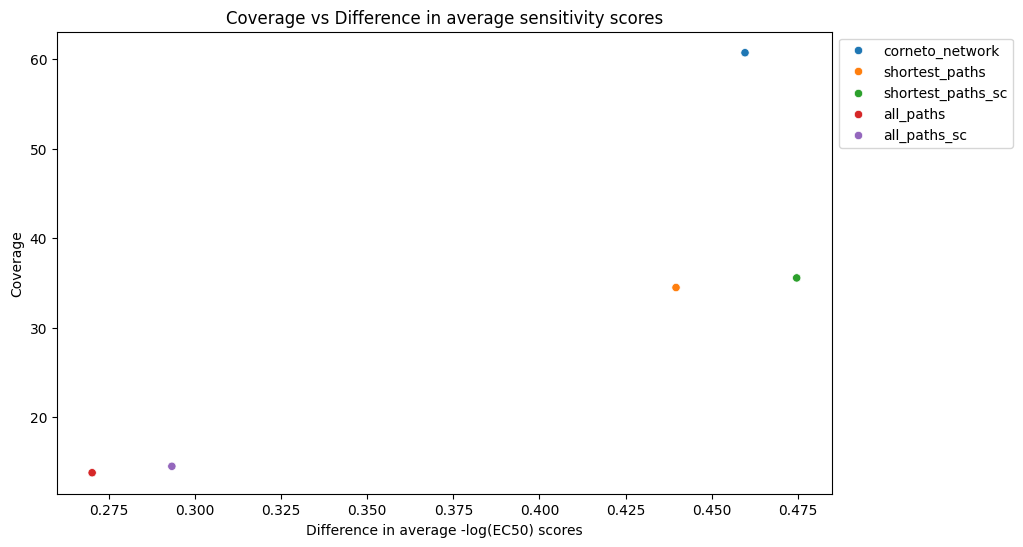

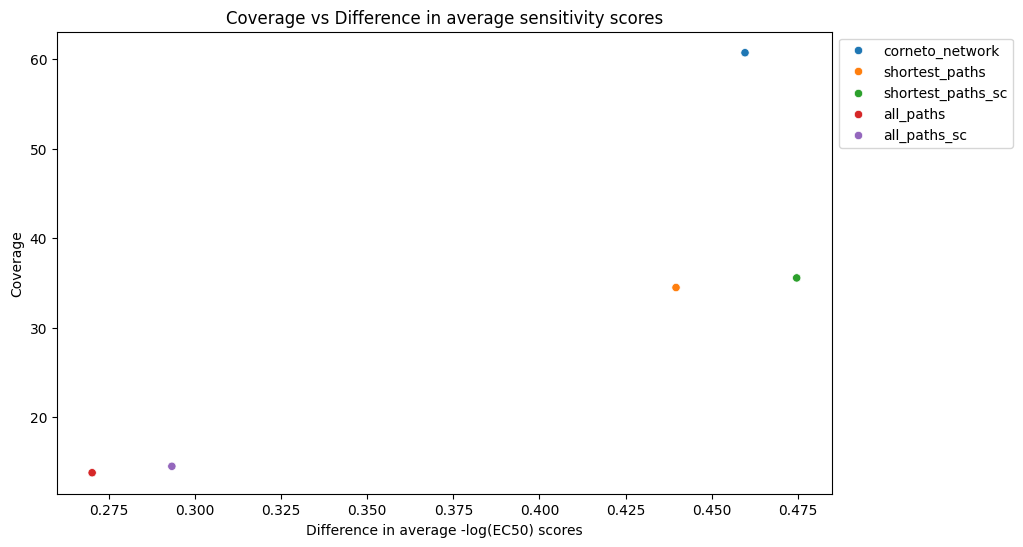

In [25]:
nc.visual.plot_scatter(
    ec50_eval_results,
    x_col='diff_EC50',  
    y_col='coverage',
    size_col=None,
    hue_col='method',
    numeric_cols=None,
    style_col=None,
    xlabel='Difference in average -log(EC50) scores',  
    ylabel='Coverage',  
    title='Coverage vs Difference in average sensitivity scores',  
    figsize=(10, 6),  
)  

Both corneto and shortest paths + sign consistency had the highest difference between EC50 values of nodes included and excluded of the solution networks. In addition, the corneto network has almost double coverage than the rest of the networks. Therefore, we would consider the corneto network a better performer, taking both dimensions into account.